# <font color='navy'> <b> Riadenie simulácie pomocou *pyelmer* </b></font>

## <font color='teal'> <b> Priklad 1. </b></font>

Simulácia elektrického pola a potenciálu dvoch gulových elektród v 2D priestore.

<img src="./sim_01/lib2d_01.png" width="600">

## <font color='teal'> <b> Vytvorenie simulačného modelu </b></font>

In [4]:
# reset prostredia, pri opakovanom spusteni generuje zle vysledky
%reset -sf --aggressive
import gmsh
from utils.lib2d import *

gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 0)  # zrusenie vypisov
                                              # defincia ulohy
R = Rectangle( 0, 0, 10, 10)                  # simulacne prostredie - vzduch
E1 = Circle(-2,0,1)                           # elektroda
E2 = Circle( 2,0,1)                           # elektroda
S = PlaneSurface([R, E1, E2])                 # konfiguracia plocha R s dierami C1,C2
                                              # fyzicka reprezentacia  ulohy
ps = PhysicalSurface(S, "Vzduch")             # (1) - poradie v Elmer
pr = PhysicalLine(R, "Okraj")                 # (2)   
pe1 = PhysicalLine(E1, "Lava elektroda")      # (3)
pe2 = PhysicalLine(E2, "Prava elektroda")     # (4)

gmsh.model.geo.synchronize()
gmsh.model.mesh.generate(2)                   # vygenerovanie 2D mriezky 

gmsh.write("./sim_01/lib2d_01.vtk")              # zapis do suborov
gmsh.write("./sim_01/lib2d_01.msh")
gmsh.write("./sim_01/lib2d_01.geo_unrolled")

gmsh.fltk.run()                              # kontrolne zobrazenie v gmsh
gmsh.finalize()


#----------------------------------------------

s = Plot(R) + Plot(E1) + Plot(E2)
from cm.utils import *
cm_compile('./img/obr_0011', s, grid=False, dpi=600, dx=10, dy=10)   
cm_show('./img/obr_0011.png', width=500)


## <font color='teal'> <b> Skript pre riadenie simulacie </b></font>

In [5]:
import os
import gmsh
from pyelmer import elmer, post
from pyelmer import execute

sim = elmer.load_simulation("2D_steady", "./sim_01/my_simulations.yml")
sim.constants.update({"Permittivity of Vacuum": "8.8542e-12"})
sim.constants.update({"Gravity(4)": "0 -1 0 9.82"})
sim.constants.update({"Boltzmann Constant": "1.3807e-23"})
sim.constants.update({"Unit Charge": "1.602e-19"})

# materials
air = elmer.load_material("air", sim, "./sim_01/my_materials.yml")

# solver
solver_electrostatic = elmer.load_solver("Electrostatics", sim, r"./sim_01/my_solvers.yml")
solver_electrostatic.data.update({"Potential Difference": "1.0"})

# equation
eqn = elmer.Equation(sim, "main", [solver_electrostatic])

# bodies
bdy_ab = elmer.Body(sim, "Plocha", [ps])
bdy_ab.material = air
bdy_ab.equation = eqn

# boundaries
bndry_m1 = elmer.Boundary(sim, "Elektroda 1", [pe1])
bndry_m1.data.update({"Potential": "10.0"})

bndry_m2 = elmer.Boundary(sim, "Elektroda 2", [pe2])
bndry_m2.data.update({"Potential": "-10.0"})

bndry_airbox = elmer.Boundary(sim, "FarField", [pr])
bndry_airbox.data.update({"Electric Infinity BC": "True"})

sim.write_startinfo('./sim_01/')
sim.write_sif('./sim_01/')

Wrote sif-file.


## <font color='teal'> <b> Spustenie simulacie </b></font>

In [6]:
execute.run_elmer_grid('./sim_01/', "lib2d_01.msh")
execute.run_elmer_solver('./sim_01/')

## <font color='teal'> <b> Vizualizácia výsledkov </b></font>

Pre vizualizáciu výsledkov simulácie je možné využiť program **Paraview** alebo knižnicu **pyvista**

    pip install pyvista
    pip install 'jupyterlab' 'pyvista[all]'
    pip install trame_jupyter_extension

<img src="./sim_01/pv_screenshot.png" width="600">


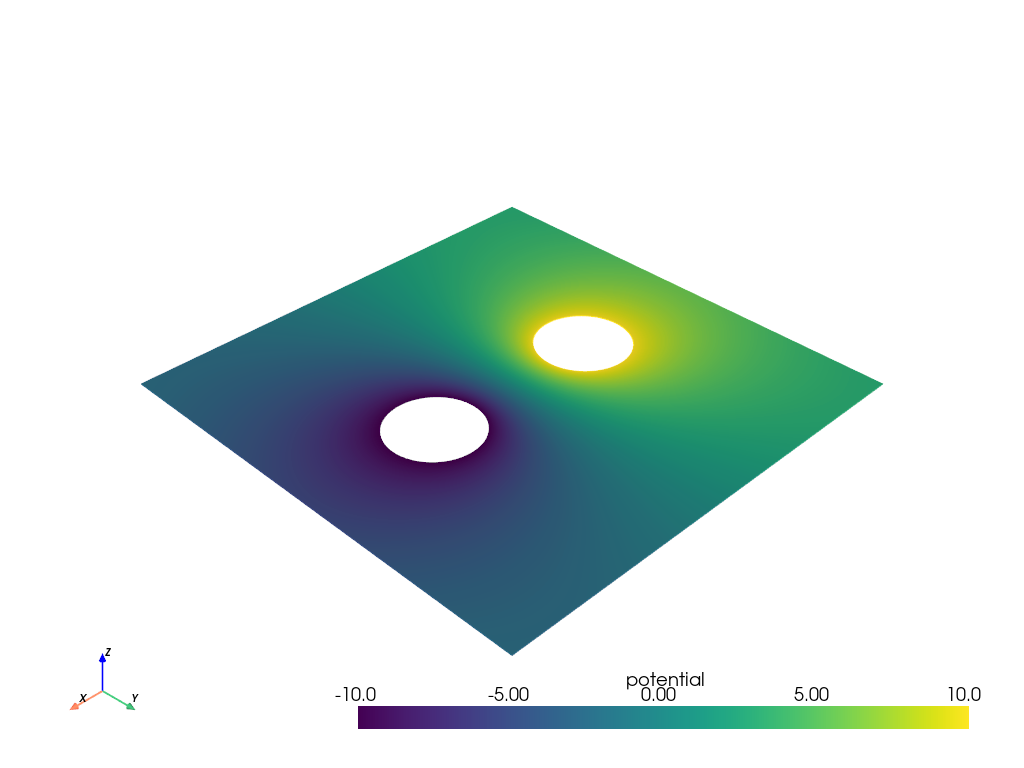

UnstructuredGrid (0x7fcc8d898640)
  N Cells:    22758
  N Points:   11378
  X Bounds:   -5.000e+00, 5.000e+00
  Y Bounds:   -5.000e+00, 5.000e+00
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   4

In [7]:
import pyvista as pv
pv.set_jupyter_backend('static')
data = pv.read('./sim_01/case_t0001.vtu')
data.plot(scalars="potential")
data